In [1]:
## Setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

The dataset weather-data.csv is obtained from [IOWA Environmental Mesonet - Iowa State University](https://mesonet.agron.iastate.edu/)

Columns for this dataset:

+ station: Acronym for the place of data capture.
+ valid: Date and time of capture.
+ tmpc: Temperature of the environment in celsius.
+ dwpc: Temperature of the dew point in the environment in celsius.
+ relh: Relative humidity of the environment in percentage.
+ sknt: Wind Speed in knots.
+ gust: Wind Gust in knots.
+ peak_wind_drct: Peak Wind Gust Direction (from PK WND METAR remark). (deg).

In [2]:
data = pd.read_csv('weather-data.csv')
data.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


At a first glance, it's easy to spot that the data is sampled at a 30-min interval, so a time series modeling can be used at a later stage.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0    station        103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


In [4]:
len(data[' station'].unique())

1

'peak_wind_drct' can be dropped as it has no non-null value, 'station' can be dropped as it has a single value of 'NZAA' and imputation should be considered for other columns where there are some missing values (the number of non-null values is less than the record number), such as 'dwpc' (103678 < 103713). 

<AxesSubplot:>

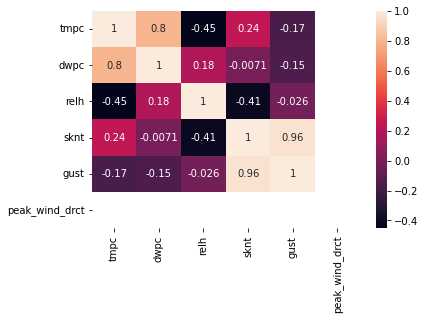

In [5]:
sns.heatmap(data.corr(), annot=True)

The dew point temperature is the temperature to which air must be cooled to become saturated with water vapor, assuming constant air pressure and water content. Therefore, it is understandably correlated with the temperature (the air needed to be cooled), relative humidity (water content) and the wind speed/gust (air pressure). Apart from that, the correlation between the wind speed and the wind gust is quite noticable.

In [6]:
data.describe()

,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000,0.0
mean,15.811503,12.115772,79.782307,8.919029,30.962594,NaN
std,4.235197,3.738005,12.562199,5.348379,6.319510,NaN
min,2.000000,-2.000000,29.230000,0.000000,13.000000,NaN
25%,13.000000,9.000000,71.450000,5.000000,27.000000,NaN
50%,16.000000,12.000000,81.990000,8.000000,31.000000,NaN
75%,19.000000,15.000000,88.180000,12.000000,35.000000,NaN
max,29.000000,23.000000,100.000000,42.000000,56.000000,NaN


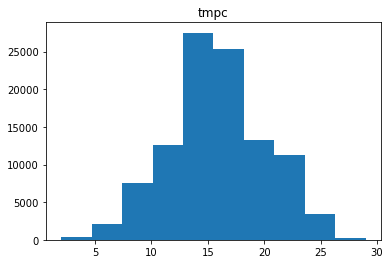

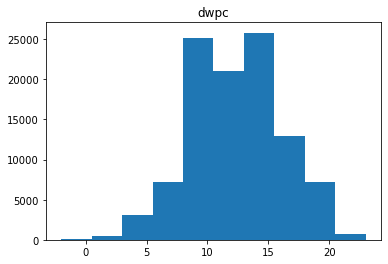

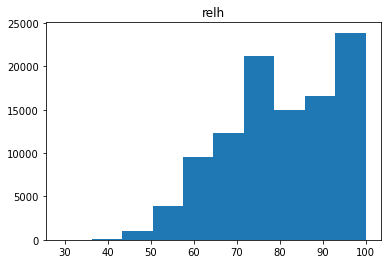

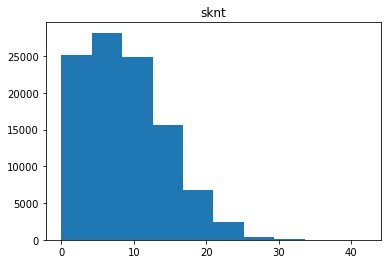

In [7]:
# distributions
for name in ['tmpc', 'dwpc', 'relh', 'sknt']:
    plt.hist(data[name])
    plt.title(name)
    plt.show()

Since they're all numeric values, we care about distributions. Temperature and dew point temperature are approximately normally distributed, while relative humidity and wind speed are skewed.

## Data Preparation

### Preprocessing

In [8]:
data.dtypes

 station           object
valid              object
tmpc              float64
dwpc              float64
relh              float64
sknt              float64
gust              float64
peak_wind_drct    float64
dtype: object

In [9]:
data['valid'] = data['valid'].astype("datetime64")


In [10]:
data.set_index('valid', inplace=True)
data.index.max()

Timestamp('2020-12-30 23:30:00')

### Imputation

In [11]:
# drop the useless columns
data.drop('peak_wind_drct', 1, inplace=True)
data.drop(' station', 1, inplace=True)

In [12]:
# When 'gust' is nan, there's assumingly no significant change in the wind speed. -> it can be filled with the wind speed at the same time point
# When other columns are nan, there's assumingly no significant change in the short time interval -> they can be filled with the average of the last and the next valid observations
data['gust'].fillna(data['sknt'], inplace=True)
data.fillna((data.fillna(method='bfill')+data.fillna(method='ffill'))/2, inplace=True)

#### Train and test sets

In [13]:
train = data[:'2020-09']
test = data['2020-10':]